# Example - Sentinel 2 Collection

In [1]:
import sentinel_collection as sc
import geopandas as gpd
import stackstac
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.cm as cm

In [2]:
aoi = gpd.read_file('../../2_data/Koumbia_db/Koumbia_JECAM_2018-20-21.shp')
time = "2018-01-01/2022-01-01"
bbox = aoi.total_bounds
cloud_cover = [10, 20, 30]

The `s2` class requires a cloud cover threshold to be created, this threshold will be evaluated as 'less than' to compute cloud cover percentage at the area of interest based on SCL: Scene classification layer, provided by ESA.

We can use the `map` function to create many instances based on a list of cloud cover values.

In [3]:
s2collections = map(sc.s2, cloud_cover)
s2collections = list(s2collections)

The main method of this class is `getReducedStack()` which returns a stackstac-xarray object that contains a data cube of Sentinel 2 L2A Collection filtered for the year 2018 to 2021 and to the study area. In addition, the cloud cover threshold is specific for the study area, and not the entire tile. 

In [4]:
stack, count = s2collections[2].getReducedStack()

/Users/edgar/opt/anaconda3/envs/GeoDS/lib/python3.11/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


In [5]:
stack

<xarray.DataArray 'stackstac-11e60983ae0f71227fc0972f0a04e57e' (time: 179,
                                                                band: 17,
                                                                y: 4513, x: 5183)>
dask.array<getitem, shape=(179, 17, 4513, 5183), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    eo:cloud_cover                           (time) float64 0.004124 ... 0.00...
    ...                                       ...
    proj:shape                               (band) object [10980, 10980] ......
    proj:transform                           (band) object [10.0, 0.0, 399960...
    common_name                              (band) object None ... None
    center_wavelength                        (band) object None 0.443 ... None
    full_width_half_max                      (band) object None 0.027 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(402570, 1212060, 454400, 1257...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 402570.00|\n| 0.00,-10.00, 1257190.00|\n| 0.0...
    resolution:  10

As we can see, the xarray data cube has 4 dimensions (time, bands, x, y), on the time dimention there are 179 objects, meaning that there are 179 images that match our cloud cover criteria, each image has 17 bands, and the images consists of 4513x5183 pixels.

The computation of the AOI cloud cover is done using the Scene Classification Layer (SCL) provided by ESA, this layer contains 12 classes:

| Bit value | Class |
|---|---|
| 0 | No data |
| 1 | Saturated or defective |
| 2 | Dark area pixels |
| 3 | Cloud shadows |
| 4 | Vegetation |
| 5 | Bare Soil |
| 6 | Water |
| 7 | Unclassified |
| 8 | Cloud medium probability |
| 9 | cloud high probability |
| 10 | Thin cirrus |
| 11 | Snow or ice |

The `getReducedStack()` method filters the SCL band to get create a cloud mask using the values 3, 8, and 9.

In [6]:
SCL = stackstac.stack(s2collections[2].getItemAll(), resolution = 10, bounds = bbox).sel(band = 'SCL')
SCL

/Users/edgar/opt/anaconda3/envs/GeoDS/lib/python3.11/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


<xarray.DataArray 'stackstac-dd2cbdd322257524d6e24a14aad821a0' (time: 278,
                                                                y: 4513, x: 5183)>
dask.array<getitem, shape=(278, 4513, 5183), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
    band                                     <U7 'SCL'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    eo:cloud_cover                           (time) float64 0.004124 ... 0.00...
    ...                                       ...
    proj:shape                               object [5490, 5490]
    proj:transform                           object [20.0, 0.0, 399960.0, 0.0...
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(402570, 1212060, 454400, 1257...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 402570.00|\n| 0.00,-10.00, 1257190.00|\n| 0.0...
    resolution:  10

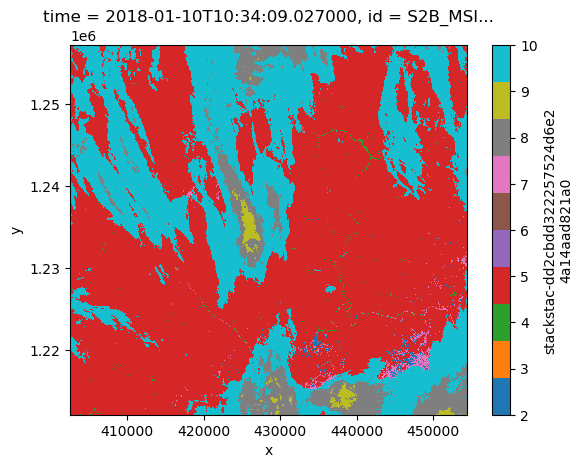

In [14]:
SCL[1, :, :].plot.imshow(cmap = 'tab10')

The coud mask is computed as the code bellow:

In [22]:
highclouds = SCL.where(SCL == 9, 0) / 9 # High probability clouds, binary mask 0, 1
medclouds = SCL.where(SCL == 8, 0) / 8 # Medium probability clouds, binary mask 0, 1
shaclouds = SCL.where(SCL == 3, 0) / 3 # Cloud shadows, binary mask 0, 1
cloudmask = highclouds + medclouds + shaclouds # Cloud mask, binary mask 0, 1


Here an example of one cloudy image:

Text(0, 0.5, '')

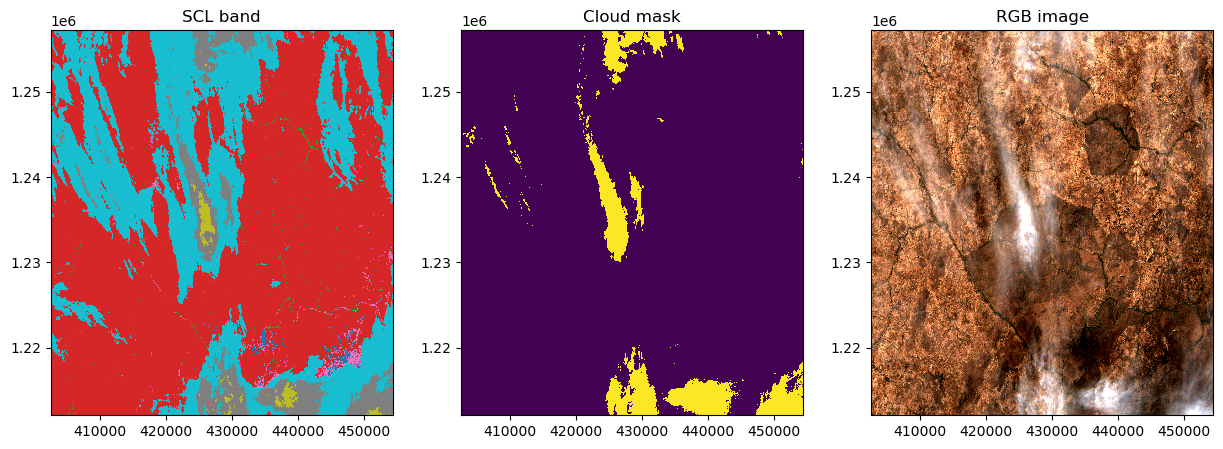

In [23]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
SCL[1, :, :].plot.imshow(cmap = 'tab10', ax = ax[0], add_colorbar = False)
ax[0].set_title('SCL band')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
cloudmask[1, :, :].plot.imshow(ax = ax[1], add_colorbar = False)
ax[1].set_title('Cloud mask')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
stack[1, :, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True, ax = ax[2])
ax[2].set_title('RGB image')
ax[2].set_xlabel('')
ax[2].set_ylabel('')

The cloud percentage is computed by summing the pixel values of the mask and diving by the total number of pixels. The image above has ~7 % of cloud cover.

In [15]:
((cloudmask[[0, 1], :, :].sum(axis = (1, 2)) / (cloudmask.shape[1] * cloudmask.shape[2]))*100).compute()

<xarray.DataArray 'stackstac-dd2cbdd322257524d6e24a14aad821a0' (time: 2)>
array([1.31675257e-03, 7.06019641e+00])
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
    band                                     <U7 'SCL'
    eo:cloud_cover                           (time) float64 0.004124 59.43
    s2:mean_solar_azimuth                    (time) float64 146.6 145.4
    s2:snow_ice_percentage                   float64 0.0
    ...                                       ...
    proj:shape                               object [5490, 5490]
    proj:transform                           object [20.0, 0.0, 399960.0, 0.0...
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32630

The `getReducedStack()` method returns the filtered stack and the count values for all Sentinel 2 images. This count values are used to filter out images in the stack using their time indexes.

In [9]:
count

<xarray.DataArray 'stackstac-5dcf0805e82cfb654b6640ab19f3decb' (time: 278)>
array([1.31675257e-03, 7.06019641e+00, 3.69374746e-03, 1.36805462e-03,
       1.39370564e-01, 8.72751554e+01, 2.56389168e+01, 4.94209730e-03,
       6.65216557e-03, 8.19122702e-03, 1.00000000e+02, 4.42907682e-03,
       4.05286180e-03, 3.31215086e+01, 5.46884920e+01, 1.05008452e+00,
       6.36218374e+01, 1.00000000e+02, 1.00000000e+02, 6.20853325e+01,
       5.86445683e+00, 1.98927796e+01, 3.71524944e+01, 1.28768141e-02,
       5.14383406e+00, 5.55755087e+01, 3.43345797e+00, 8.72117418e+01,
       3.73543765e+01, 5.79371985e+00, 1.00000000e+02, 7.96059310e+01,
       8.70209495e+01, 9.59004106e+01, 3.06341630e-01, 3.66467630e-02,
       7.93449318e+01, 5.04577019e+00, 5.98184061e+01, 5.91708888e+01,
       9.41176986e+01, 6.10976227e+01, 7.16708808e+01, 8.43971832e+01,
       9.87551131e+01, 8.71189108e+01, 3.45842240e+01, 1.00000000e+02,
       4.53279203e+01, 1.29004045e+01, 7.57719280e+00, 9.19987188e+01,
       2.05208192e-04, 4.85231829e+01, 1.32573043e-01, 3.65242024e+01,
       3.40956917e+01, 6.63506489e-03, 2.05892220e-02, 1.53906144e-04,
       9.98293694e+01, 2.73610923e-04, 4.61718433e-04, 6.84027308e-05,
       6.15624577e-04, 5.47221847e-04, 1.00894028e-03, 1.69113781e+00,
       2.90266988e-01, 9.11702378e+00, 4.96290883e+00, 8.37933453e-04,
       1.28255120e-03, 5.65157043e+00, 1.52196076e-03, 6.20925789e-02,
       4.86637334e+01, 1.31675257e-03, 4.73688911e-03, 6.00233963e-03,
...
       6.84027308e-04, 5.81423212e-04, 1.24834984e-03, 8.55034135e-04,
       1.55616213e-03, 4.10416385e-04, 9.94062686e-02, 1.53906144e-04,
       7.35329356e-04, 1.74426964e-03, 2.78741128e-03, 4.44617750e-04,
       6.15624577e-04, 2.25729012e-03, 3.26623040e-03, 1.03353534e+00,
       5.62612461e-03, 4.70268774e-03, 3.77241061e-02, 5.06180208e-03,
       9.99847120e+01, 4.15546590e-03, 1.68464811e+00, 1.83148312e-02,
       4.60542761e+00, 1.86525697e+00, 7.35331964e+01, 4.92499662e-03,
       6.88364426e+01, 8.27673043e-03, 7.19938742e-03, 2.62159451e+00,
       4.44532247e-01, 9.88419460e-03, 2.74127364e+00, 9.72675888e+01,
       7.02838059e-03, 1.00000000e+02, 1.82626741e-01, 2.73952937e-02,
       9.43726441e+01, 1.17969060e-01, 1.95976816e+01, 7.51232991e-02,
       3.82594173e+01, 3.11574439e-02, 6.79244076e+01, 3.92118654e-02,
       8.23053336e+01, 1.78442546e+01, 6.32567806e+01, 9.99699883e+01,
       2.99439110e+01, 6.40647793e+01, 1.00000000e+02, 9.89700601e+01,
       4.62127738e+01, 9.99893677e+01, 1.07905308e-02, 2.69391330e+00,
       3.21851094e+01, 4.42265295e+01, 2.56836949e+01, 4.51458023e-03,
       5.36787865e+01, 1.48336452e+00, 1.73796632e+01, 4.39487546e-03,
       3.09219589e+01, 6.84027308e-04, 6.15624577e-04, 2.60140032e+01,
       7.66721080e+00, 2.56510241e-04, 7.32729497e+01, 6.84027308e-04,
       2.79708941e+01, 7.69530722e-04])
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
    band                                     <U7 'SCL'
    s2:granule_id                            (time) <U62 'S2A_OPER_MSI_L2A_TL...
    s2:datastrip_id                          (time) <U64 'S2A_OPER_MSI_L2A_DS...
    s2:not_vegetated_percentage              (time) float64 99.11 ... 96.29
    ...                                       ...
    proj:shape                               object [5490, 5490]
    proj:transform                           object [20.0, 0.0, 399960.0, 0.0...
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32630

If we compare the number of images that are filtered using the cloud cover measure at the tile level with the AOI level we get the following results for a threshold of 30 percent.

In [12]:
print('Total # of images: ', len(s2collections[2].getItemAll()))
print('# of images using tile level cloud cover: ', len(s2collections[2].getItem()))
print('# of images using AOI level cloud cover: ', len(count.where(count < 30).dropna('time')))

Total # of images 278
# of images using tile level cloud cover 147
# of images using AOI level cloud cover 179


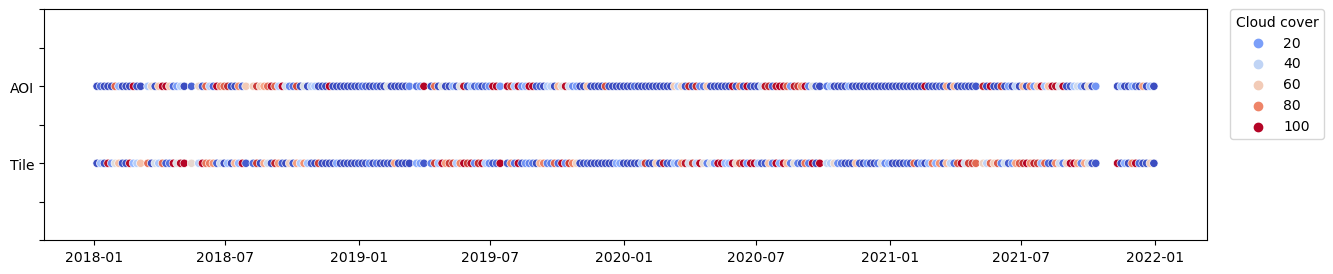

In [48]:
plt.figure(figsize = (15, 3))
sns.scatterplot(
    x = count.indexes['time'], 
    y = np.array([1]*278), 
    hue = s2collections[2].getDFAll()['eo:cloud_cover'], 
    palette= cm.coolwarm,
    legend = False)
sns.scatterplot(
    x = count.indexes['time'], 
    y = np.array([2]*278), 
    hue = count, 
    palette= cm.coolwarm,)
plt.ylim(0, 3)
plt.xlabel('')
plt.yticks(ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3], labels = ['', '', 'Tile', '', 'AOI', '', ''])
plt.legend(
    title = 'Cloud cover',
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    borderaxespad=0, 
)


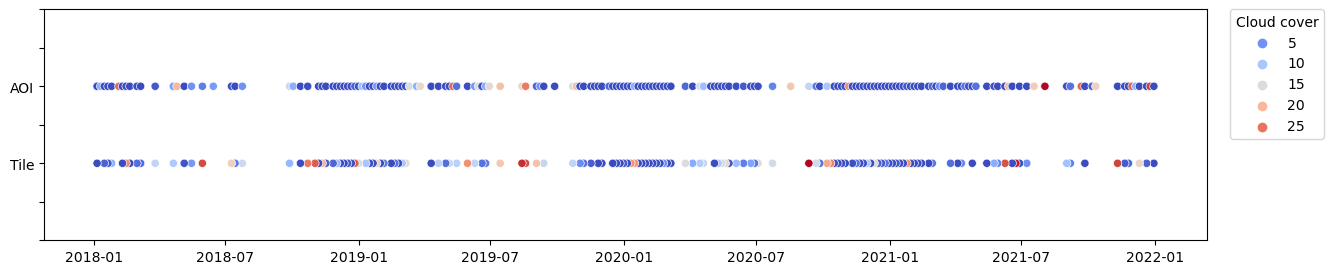

In [46]:
plt.figure(figsize = (15, 3))
sns.scatterplot(
    x = s2collections[2].getDF()['datetime'], 
    y = np.array([1]*len(s2collections[2].getDF()['eo:cloud_cover'])), 
    hue = s2collections[2].getDF()['eo:cloud_cover'], 
    palette= cm.coolwarm,
    legend = False)
sns.scatterplot(
    x = count.where(count < 30).dropna('time').indexes['time'], 
    y = np.array([2]*len(count.where(count < 30).dropna('time'))), 
    hue = count.where(count < 30).dropna('time'), 
    palette= cm.coolwarm,)
plt.ylim(0, 3)
plt.xlabel('')
plt.yticks(ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3], labels = ['', '', 'Tile', '', 'AOI', '', ''])
plt.legend(
    title = 'Cloud cover',
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    borderaxespad=0, 
)